Code adopted from :
https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb


In [172]:
#!pip install imageio
#!pip install tensorflow

# https://stackoverflow.com/questions/58947434/cant-use-gpu-on-google-colab-for-tensorflow-2-0
#!pip install tensorflow-gpu
#!pip install tf-nightly

In [173]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())

2.2.0



In [174]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [175]:
# get data from:
# http://mathieu.delalandre.free.fr/projects/sesyd/symbols/floorplans.html
#!wget -nc http://mathieu.delalandre.free.fr/projects/sesyd/symbols/floorplans/floorplans16-01.zip
#!unzip -q -o -d data/ floorplans16-01.zip

DATA_DIR = 'data/'
print(os.listdir(DATA_DIR))

['floorplans16-01']


In [176]:
BUFFER_SIZER = 60000
BATCH_SIZE = 32
image_size = 32
noise_dim = 128

In [177]:
# https://medium.com/@a.ydobon/tensorflow-2-0-load-images-to-tensorflow-897b8b067fc2
DATA_DIR = 'data/'

# https://stackoverflow.com/questions/54606302/tf-data-dataset-from-tf-keras-preprocessing-image-imagedatagenerator-flow-from-d
def make_generator():
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale = 1./255,
        featurewise_center = False,
        samplewise_center = True)
    train_generator = train_datagen.flow_from_directory(
        DATA_DIR,
        target_size = (image_size, image_size),
        class_mode = 'categorical',
        batch_size = BATCH_SIZE,
        color_mode = 'grayscale'
    )
    return train_generator
    
images_dataset = tf.data.Dataset.from_generator(make_generator, (tf.float32, tf.float32))

In [178]:
for i,(j,k) in enumerate(images_dataset):
    train_Dataset = tf.data.Dataset.from_tensors(j)
    break    

Found 101 images belonging to 1 classes.


In [179]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense((image_size//4)*(image_size//4)*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((image_size//4, image_size//4, 256)))

    assert model.output_shape == (None, image_size//4,image_size//4, 256) # None = batch size

    model.add(layers.Conv2DTranspose(128,(5,5), strides = (1,1), padding = 'same', use_bias=False))
    assert model.output_shape == (None, image_size//4,image_size//4,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5,5), strides = (2,2), padding = 'same', use_bias=False))
    assert model.output_shape == (None, image_size//2,image_size//2,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1,(5,5), strides = (2,2), padding = 'same', use_bias=False, activation='tanh'))
    #print(model.output_shape)
    assert model.output_shape == (None, image_size,image_size,1)

    return model

generator = make_generator_model()

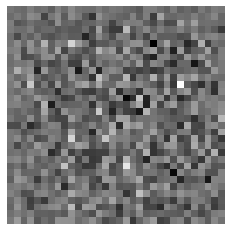

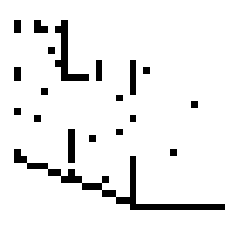

In [180]:
# show initial dataset and inital noise
for _, image_batch in enumerate(train_Dataset):
    img = image_batch
    break

noise = tf.random.normal([1,noise_dim])
generated_image = generator(noise, training = False)
plt.figure()
plt.imshow(generated_image[0, :, :, 0], cmap = 'gray')
plt.axis('off')
plt.figure()
plt.imshow(img[0,:,:,0], cmap = 'gray')
plt.axis('off')

plt.show()

In [181]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides = (2,2), padding = 'same', input_shape=[image_size,image_size,1]))

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [182]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00040649]], shape=(1, 1), dtype=float32)


In [183]:
for _,image_batch in enumerate(train_Dataset):
    print(image_batch.shape)
    real_output = discriminator(image_batch, training = False)
    print (real_output.shape)
    
    break

(32, 32, 32, 1)
(32, 1)


In [184]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [185]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [186]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [187]:
#Checkpoints for long training
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'checkpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [188]:
# the training loop
EPOCHS = 900

num_examples_to_generate = 9

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [189]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output=fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [190]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            # print (gen_loss, disc_loss)
            
        
        #produce images for the gif
        display.clear_output(wait = True)
        generate_and_save_images(generator,
                                 epoch+1,
                                 seed)
        
        #save model every 15 epochs
        #if (epoch+1)%15 == 0:
            #checkpoint.save(file_prefix = checkpoint_prefix)

        print('Time for epoch {} is {:0.4} s'.format(epoch+1, time.time()-start))
        generator_history.append(gen_loss)
        discriminator_history.append(disc_loss)
        print('Generator loss:{:0.4} Discriminator loss:{:0.4}'.format(gen_loss, disc_loss))
    
    display.clear_output(wait = True)
    generate_and_save_images(generator,
                             epochs,
                             seed)

In [191]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training = False)

    fig = plt.figure(figsize=(3,3))

    for i in range (predictions.shape[0]):
        plt.subplot(3,3, i+1)
        plt.imshow(predictions[i, :, :, 0]*255/2 + 255/2, cmap='gray')
        plt.axis('off')
    
    plt.savefig('generated/image_at_epoch{:04d}.png'.format(epoch))
    plt.show()

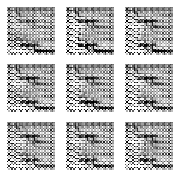

Time for epoch 120 is 1.059 s
Generator loss:7.984 Discriminator loss:0.002965


In [ ]:
generator_history = []
discriminator_history = []
train(train_Dataset, EPOCHS)

In [ ]:
# Visualize loss history
plt.plot( generator_history, 'r--')
plt.plot( discriminator_history, 'b-')
plt.legend(['generator_history', 'discriminator_History'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
#Create gif
def display_image(epoch_no):
    return PIL.Image.open('generated/image_at_epoch{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

In [ ]:
# use imageio to create animated gif using images 
anim_file = 'dcgan.gif'

with imageio. get_writer(anim_file, mode = 'I') as writer:
    filenames = glob.glob('generated/image*.png')
    filenames = sorted(filenames)

    last = -1

    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if (round(frame)> round(last)):
            last = frame
        else:
            continue
        
        image = imageio.imread(filename)
        writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

In [ ]:
# download gif:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)

In [ ]:
for _, image_batch in enumerate(train_Dataset):
    img = image_batch
    break

noise = tf.random.normal([1,noise_dim])
generated_image = generator(noise, training = False)
plt.figure()
plt.imshow(generated_image[0, :, :, 0], cmap = 'gray')
plt.axis('off')
plt.figure()
plt.imshow(img[0,:,:,0], cmap = 'gray')
plt.axis('off')

plt.show()